# Project_2 Illegal Cheetah Trade Analysis

### Note: see README for environment and package installation instructions. 
Also, export functions of images to .png files have been commented out of this notebook for submission. 

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import numpy as np
import re
import csv
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file, export_png
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, FixedTicker
from bokeh.palettes import Magma256, RdYlGn, Turbo256

## Note about Font selections for graphs: 

Utilize below settings for font size and legend location.

fig.axes.title.set_size(28)

fig.set_xlabel('Year', fontdict={'fontsize':18})

fig.set_ylabel('# of Incidents', fontdict={'fontsize':18})

fig.legend(loc=1,fontsize=12)

plt.xticks(fontsize=12)

## Note about Color selections for graphs: 
Utilize "terrain", a colormap in matplotlib. For graphs with multiple datsets represented, use colormap = 'terrain'. 

For graphs representing a single dataset, select from color below. 

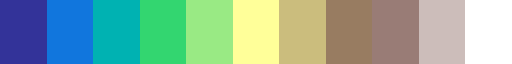

In [2]:
graph_palette = plt.get_cmap('terrain', 11)
graph_palette

In [3]:
#Hex Color codes for each color above
hex_list = []
for color in range(graph_palette.N):
    rgba = graph_palette(color)
    hex_list.append(mcolors.rgb2hex(rgba))
#Remove white (#ffffff') from hex_list 
hex_list.remove('#ffffff')
hex_list

['#333399',
 '#1177dd',
 '#00b2b2',
 '#33d670',
 '#99eb85',
 '#ffff99',
 '#ccbe7d',
 '#997c62',
 '#997c76',
 '#ccbebb']

## Functions

In [4]:
def convert_usd(row):
    if (row['Price UOM'] != 'Unknown'):
        price = row['Price']
        price_uom = row['Price UOM']
        year = row['Year']
        exchangerate = float(dict_exchangerate[price_uom + "_" + str(year)])
        price_usd = float(price) * exchangerate
        return price_usd
    else:
        return 0

## Data Import & Clean-up

In [5]:
# Load data from the source Excel file
df_cheetah = pd.DataFrame(pd.read_excel('Tricorache et al_Global trade dataset for cheetah.xlsx', header=0, usecols='A:AL'))

# Clean up the dataframe by removing the two rows at the top (data descriptions / total row)
df_cheetah.drop([0,1], inplace=True)

# Use regular expressions to extract additional data currently stored in a string description field
df_cheetah['Price'] = df_cheetah['Incident Description'].str.extract('Price: (\d*?) \w\w\w', expand=True)
df_cheetah['Price UOM'] = df_cheetah['Incident Description'].str.extract('Price: \d*? (\w\w\w)', expand=True)

# Correct typos in the price data set
df_cheetah['Price UOM'].replace('AER','AED')
df_cheetah['Price UOM'] = df_cheetah['Price UOM'].fillna('Unknown')

# Filter out data from unreliable sources
df_cheetah = df_cheetah[(df_cheetah['Report grading'] =='A') | (df_cheetah['Report grading'] =='B') | (df_cheetah['Report grading'] =='C') | (df_cheetah['Report grading'] =='D')]
df_cheetah = df_cheetah[(df_cheetah['Ult. Source Reliability'] =='A') | (df_cheetah['Ult. Source Reliability'] =='B') | (df_cheetah['Ult. Source Reliability'] =='C') | (df_cheetah['Ult. Source Reliability'] =='D')]

# Convert columns to the appropriate data type (replaces missing or string data with NaN)
df_cheetah['# Cheetahs'] = df_cheetah['# Cheetahs'].apply(pd.to_numeric, errors='coerce')
df_cheetah['Incident Date'] = df_cheetah['Incident Date'].apply(pd.to_datetime, errors='coerce')
df_cheetah['Price'] = df_cheetah['Price'].apply(pd.to_numeric, errors='coerce')
df_cheetah['Price UOM'] = df_cheetah['Price UOM'].astype(str)
df_cheetah['Year'] = df_cheetah['Incident Date'].dt.year

#Titlecase entries in Units column
df_cheetah['Units'] = df_cheetah['Units'].str.title()

# Convert the prices to USD based on the historical exchange rate and a custom function
# Note: Python packages were explored but they either did not contain enough historic data or were missing currencies so an exchange rate file and dictionary is being used.

reader = csv.reader(open('CurrencyExchangeRates.csv'))

next(reader, None)  # skip the headers in the file

dict_exchangerate = {}
for row in reader:
    key = row[0]
    if key in dict_exchangerate:
        pass
    dict_exchangerate[key] = row[1]

df_cheetah['Price USD'] = df_cheetah.apply(convert_usd, axis=1)

#df_cheetah.dtypes
#df_cheetah.head(5)

# Data Structure
An overview of the primary data source used in this analysis: The global dataset for seized and non-intercepted illegal cheetah trade

1. An overview of the data source, including record count and columns

In [6]:
df_cheetah.shape

(1166, 41)

In [7]:
list(df_cheetah.columns)

['Incident No.',
 'Incident Type',
 'Incident Date',
 'Discovery Date',
 'Country Role',
 'Region',
 'Country',
 'City/Region',
 'Location Type',
 'Origin if known',
 'Transit if known',
 'Destination if known',
 'Report grading',
 'Verif means',
 'Ultimate source type',
 'Ult. Verif. Source',
 'Ult. Source Reliability',
 'Orig. Source Type',
 'Medium',
 'Original Source',
 'Day',
 'Month',
 'Year',
 'Day (+/-)',
 'Month (+/-)',
 '# Cheetahs',
 'Units',
 'Incident Description',
 'Confiscated',
 'Surrendered',
 'Alive',
 'Died',
 'LTF/ UNK Fate',
 'Action Taken',
 'Outcome',
 'Detecting agency',
 'POI Assigned ID',
 'Other info / URL',
 'Price',
 'Price UOM',
 'Price USD']

In [8]:
#Check range of years in dataset to make sure it only represents 2010-2019.
df_cheetah['Incident Date'].dt.year.describe()

count    1166.000000
mean     2014.831904
std         2.044789
min      2010.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2019.000000
Name: Incident Date, dtype: float64

# Preliminary Data Insights
An initial analysis of the global dataset for seized and non-intercepted illegal cheetah trade utilized in project proposal phase. 

 **1. How many trafficking incidents have there been each year and has the trend changed over time?**

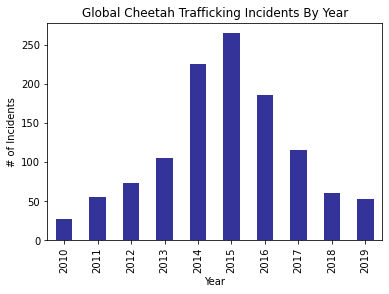

In [9]:
df_cheetah.groupby(df_cheetah['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents',xlabel='Year',title='Global Cheetah Trafficking Incidents By Year',color='#333399')
pass

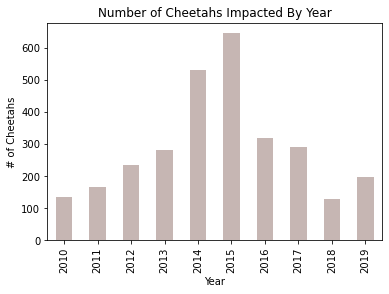

In [10]:
df_cheetah.groupby(df_cheetah['Incident Date'].dt.year)['# Cheetahs'].sum().plot(kind='bar',ylabel='# of Cheetahs',xlabel='Year',title='Number of Cheetahs Impacted By Year', color='#c6b6b3')
pass

*Insight: Global cheetah trafficking grew in the early 2010s but peaked in 2016 and has generally been declining since. While we have seen this trend to consistent based on the number of incidents as well as the number of cheetahs involved, there was a noticeable increase in the number of cheetahs involved in each incident in 2019.*

**2. Which countries are most involved in the illegal trade of Cheetahs? (Includes intercepts at the origin, in-transit and at the destination)**

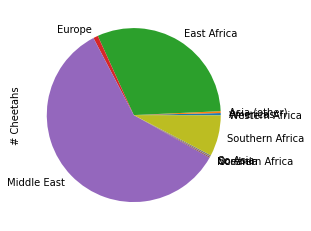

In [11]:
df_cheetah.groupby('Region')['# Cheetahs'].sum().plot(kind='pie')
pass

In [12]:
df_cheetah.where(df_cheetah['Region']=='Middle East').groupby('Country')['# Cheetahs'].sum().nlargest(5)

Country
Saudi Arabia    1006.0
UAE              386.0
Yemen            154.0
Kuwait           137.0
Qatar             25.0
Name: # Cheetahs, dtype: float64

*Insight: The middle east is the dominant region involved in trafficking incidents and primarily driven by Saudi Arabia.*

**3. What type of trade is occurring and in what form was the cheetah intercepted?**

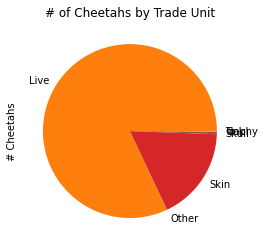

In [13]:
df_cheetah.groupby('Units')['# Cheetahs'].sum().plot(kind='pie',title='# of Cheetahs by Trade Unit')
pass

*Insight: The dataset indicates live cheetahs are the primary type of trade or the main focus of trafficking enforcement (as other types of trade could be underreported in the data).*

## Analysis of Source of Incident report

1. Analysis of source of incident by source type

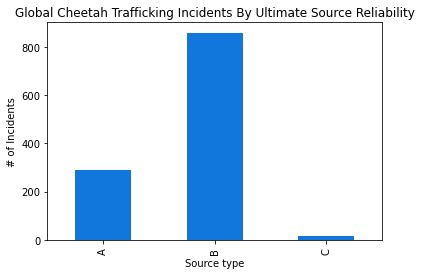

In [14]:
df_cheetah.groupby(df_cheetah['Ult. Source Reliability']).size().plot(kind='bar',ylabel='# of Incidents',xlabel='Source type',title='Global Cheetah Trafficking Incidents By Ultimate Source Reliability',color='#1177dd')
pass

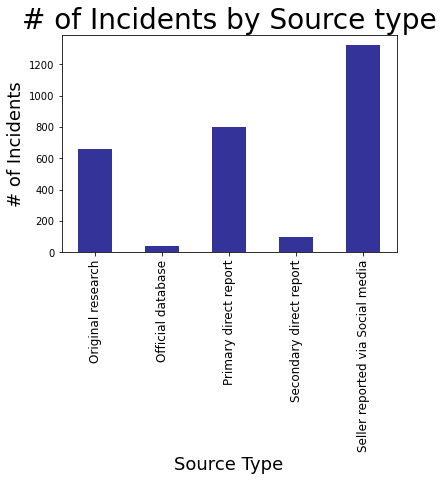

In [15]:
fig = df_cheetah.groupby('Ultimate source type')['# Cheetahs'].sum().plot(kind='bar',title='# of Incidents by Source type', color = "#333399")

labels = [item.get_text() for item in fig.get_xticklabels()]
labels[0] = 'Original research'
labels[1] = 'Official database'
labels[2] = 'Primary direct report'
labels[3] = 'Secondary direct report'
labels[4] = 'Seller reported via Social media'
fig.set_xticklabels(labels) 

fig.axes.title.set_size(28)
fig.set_xlabel("Source Type", fontdict={'fontsize':18})
fig.set_ylabel("# of Incidents", fontdict={'fontsize':18})
plt.xticks(fontsize=12);
                          

Insight: The majority of the dataset comes from source E (seller), C (primary), and A (official).

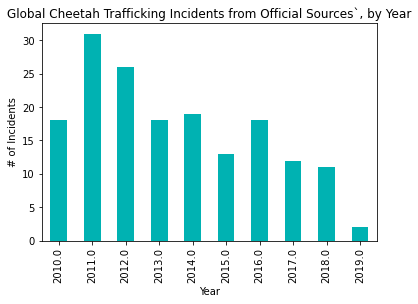

In [16]:
df_ultimate_source_type_a = df_cheetah.where(df_cheetah['Ultimate source type'] == 'A')

df_ultimate_source_type_a.groupby(df_ultimate_source_type_a['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents from Official Sources`, by Year', color='#00b2b2');



Insight: There is a declining trend in reports from official sources.

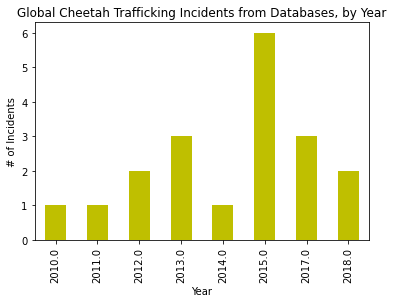

In [17]:
df_ultimate_source_type_b = df_cheetah.where(df_cheetah['Ultimate source type'] == 'B')

df_ultimate_source_type_b.groupby(df_ultimate_source_type_b['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents from Databases, by Year', color='y');

Insight: There is an increasing trend in reports from databases, however it represents a small percentage of the total data.

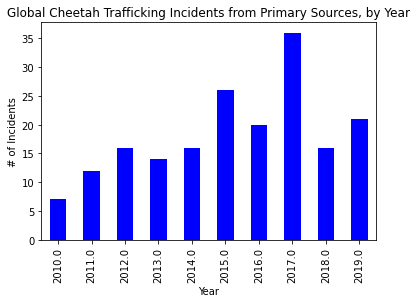

In [18]:
df_ultimate_source_type_c = df_cheetah.where(df_cheetah['Ultimate source type'] == 'C')

df_ultimate_source_type_c.groupby(df_ultimate_source_type_c['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents from Primary Sources, by Year', color='b');

Insight: There is an increasing trend in reports from primary sources.

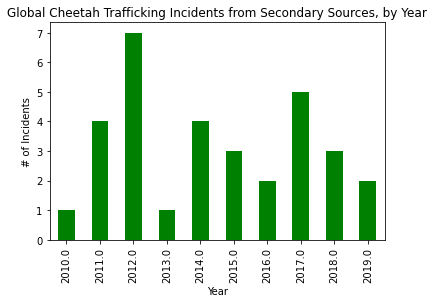

In [19]:
df_ultimate_source_type_d = df_cheetah.where(df_cheetah['Ultimate source type'] == 'D')

df_ultimate_source_type_d.groupby(df_ultimate_source_type_d['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents from Secondary Sources, by Year', color='g');

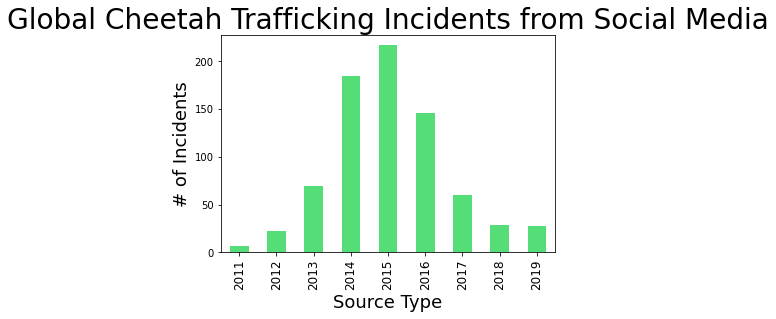

In [20]:
df_ultimate_source_type_e = df_cheetah.where(df_cheetah['Ultimate source type'] == 'E')

fig = df_ultimate_source_type_e.groupby(df_ultimate_source_type_e['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents from Social Media', color='#55dd77')

fig.axes.title.set_size(28)
fig.set_xlabel("Source Type", fontdict={'fontsize':18})
fig.set_ylabel("# of Incidents", fontdict={'fontsize':18})
plt.xticks(fontsize=12)

labels = [item.get_text() for item in fig.get_xticklabels()]
labels[0] = '2011'
labels[1] = '2012'
labels[2] = '2013'
labels[3] = '2014'
labels[4] = '2015'
labels[5] = '2016'
labels[6] = '2017'
labels[7] = '2018'
labels[8] = '2019'
fig.set_xticklabels(labels);

# plt.savefig('bar_plot_2.png')

Insight: Incidents reported to be advertised on social media decreases starting in 2016

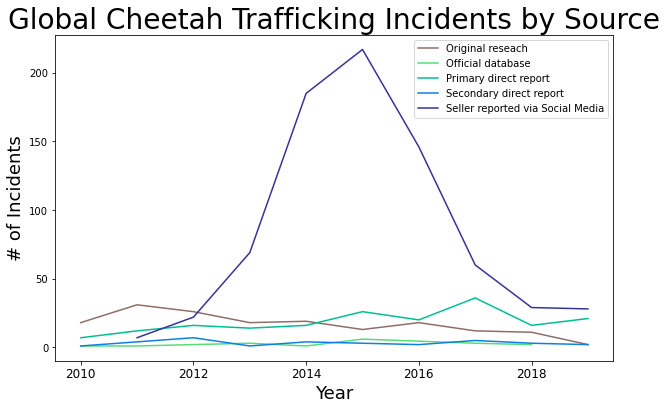

In [21]:
fig = df_ultimate_source_type_a.groupby(df_ultimate_source_type_a['Incident Date'].dt.year).size().plot(kind='line',legend=True,ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Source', color='#8e6e67', label="Original reseach", figsize = (10, 6))
fig = df_ultimate_source_type_b.groupby(df_ultimate_source_type_b['Incident Date'].dt.year).size().plot(kind='line',legend=True,ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Source', color='#55dd77', label="Official database")
fig = df_ultimate_source_type_c.groupby(df_ultimate_source_type_c['Incident Date'].dt.year).size().plot(kind='line',legend=True,ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Source', color='#00be90', label="Primary direct report")
fig = df_ultimate_source_type_d.groupby(df_ultimate_source_type_d['Incident Date'].dt.year).size().plot(kind='line',legend=True,ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Source', color='#0d7fe5', label="Secondary direct report")
fig = df_ultimate_source_type_e.groupby(df_ultimate_source_type_e['Incident Date'].dt.year).size().plot(kind='line',legend=True,ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Source', color='#333399', label="Seller reported via Social Media")

fig.axes.title.set_size(28)
fig.set_xlabel('Year', fontdict={'fontsize':18})
fig.set_ylabel('# of Incidents', fontdict={'fontsize':18})
fig.legend(loc=1,fontsize=12, prop={'size': 10})
plt.xticks(fontsize=12);

# plt.savefig('line_plot_1.png')

Insight: There is a stable trend in reports from secondary sources, with peaks in 2012 and 2017. This represents a small percentage of the dataset. Seller sources of data increased significantly between 2011-2015 and then declined rapidly between 2016-2019. The increase in incidents in the database was due to growth in social media followed by traffickers figuring out how to hide better on the internet

## Trends in African Convention countries

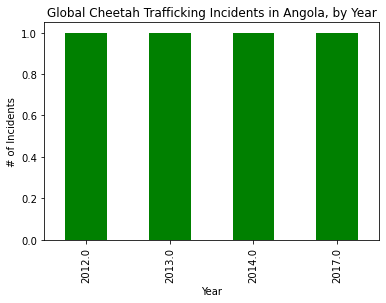

In [22]:
df_african_convention_country_filter_angola = df_cheetah.where(df_cheetah['Country'] == 'Angola')
df_african_convention_country_filter_benin = df_cheetah.where(df_cheetah['Country'] == 'Benin')
df_african_convention_country_filter_burkinafaso = df_cheetah.where(df_cheetah['Country'] == 'Burkina Faso')
df_african_convention_country_filter_chad = df_cheetah.where(df_cheetah['Country'] == 'Chad')
df_african_convention_country_filter_mali = df_cheetah.where(df_cheetah['Country'] == 'Mali')
df_african_convention_country_filter_niger = df_cheetah.where(df_cheetah['Country'] == 'Niger')
df_african_convention_country_filter_sa = df_cheetah.where(df_cheetah['Country'] == 'South Africa')

df_african_convention_country_filter_angola.groupby(df_african_convention_country_filter_angola['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents in Angola, by Year', color='g');

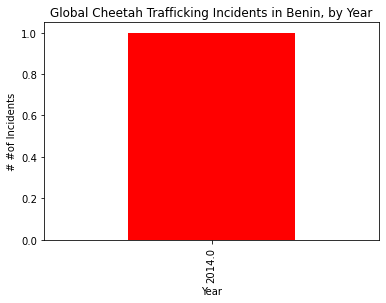

In [23]:
df_african_convention_country_filter_benin.groupby(df_african_convention_country_filter_benin['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# #of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents in Benin, by Year', color='r');

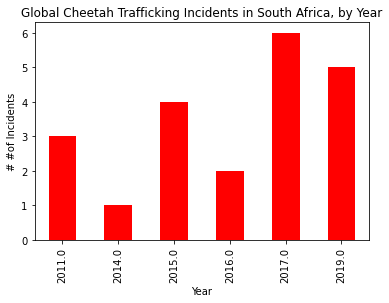

In [24]:
df_african_convention_country_filter_sa.groupby(df_african_convention_country_filter_sa['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# #of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents in South Africa, by Year', color='r');

## Cheetah Incident Price analysis

**Has price of cheetahs changed over time (after considering historical exchange rates and converting to USD)?**

A) First examine the price spread and see if there are extreme outliers that need to be removed:

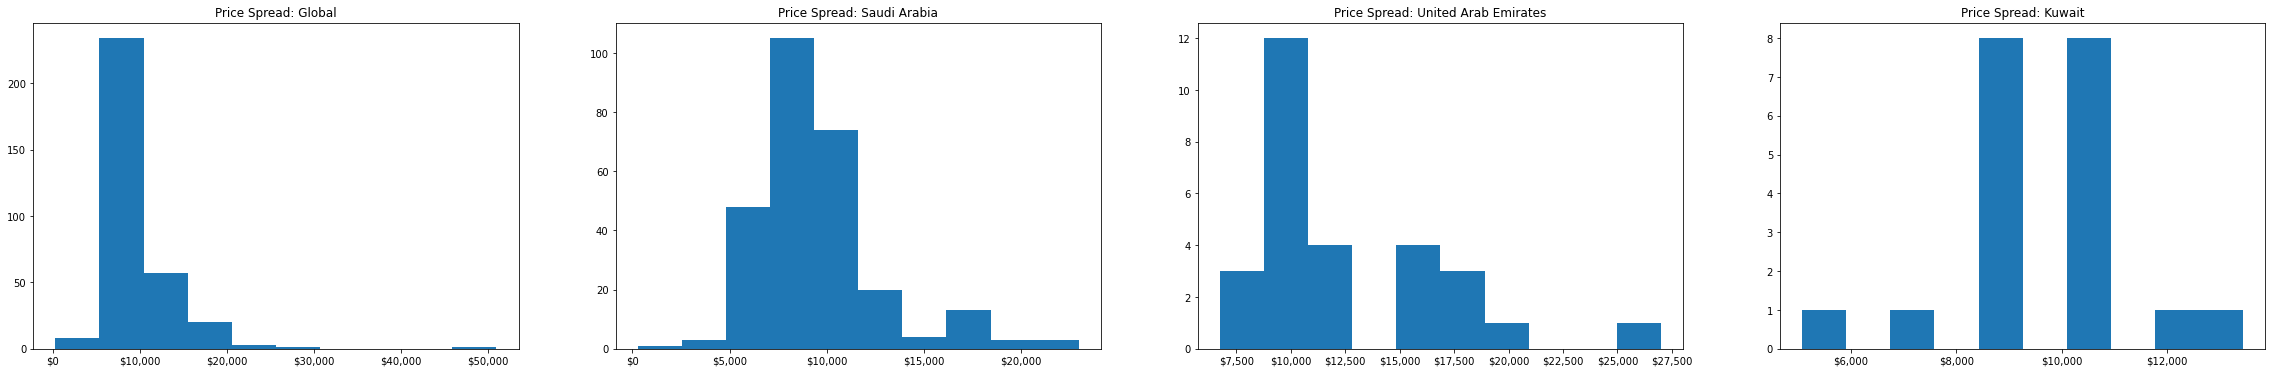

In [25]:

fig = plt.figure(figsize = (40,6))

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

ax1.set_title('Price Spread: Global')
ax1.xaxis.set_major_formatter(tick)
ax1.hist(df_cheetah['Price USD'].where((df_cheetah['Price UOM']!='Unknown') & (df_cheetah['Units']=='Live'))) # Ignore cases where there is no price or the currency is unknown

ax2.set_title('Price Spread: Saudi Arabia')
ax2.xaxis.set_major_formatter(tick)
ax2.hist(df_cheetah['Price USD'].where((df_cheetah['Price UOM']=='SAR') & (df_cheetah['Units']=='Live')))

ax3.set_title('Price Spread: United Arab Emirates')
ax3.xaxis.set_major_formatter(tick)
ax3.hist(df_cheetah['Price USD'].where((df_cheetah['Price UOM']=='AED') & (df_cheetah['Units']=='Live')))

ax4.set_title('Price Spread: Kuwait')
ax4.xaxis.set_major_formatter(tick)
ax4.hist(df_cheetah['Price USD'].where((df_cheetah['Price UOM']=='KWD') & (df_cheetah['Units']=='Live')))
pass

Result: There are a few extreme data points that upon examination appear to be typos (missing a zero or including an extra zero). We will filter out prices less than \$2,000 USD and greater than $35,000, then look at how average prices have changed over time.

B) Now plot the price in USD by year to see if supply/demand changes have impacted prices.

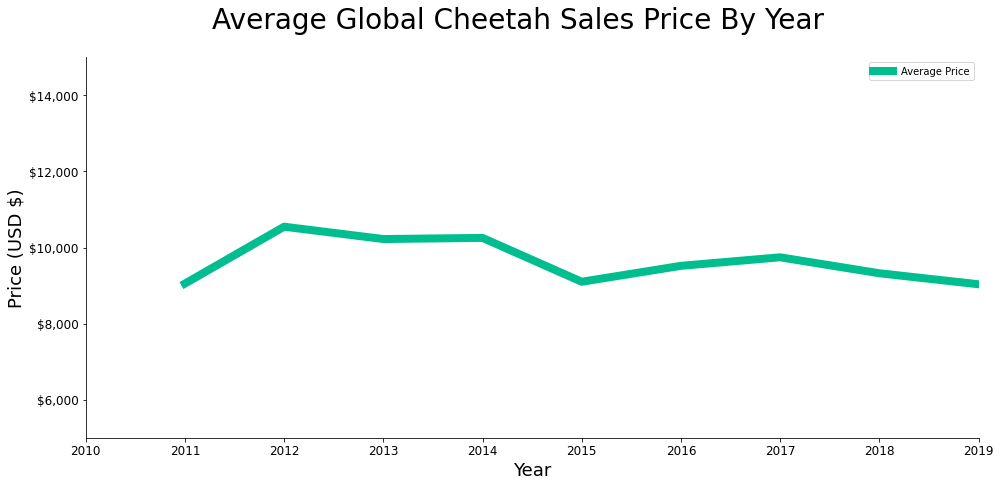

In [26]:
df_cheetah.where((df_cheetah['Price UOM']!='Unknown') & (df_cheetah['Units']=='Live') & (df_cheetah['Price USD']>2000) & (df_cheetah['Price USD']<35000) ).groupby(df_cheetah['Incident Date'].dt.year)['Price USD'].mean().plot(kind='line',legend=True, color='#00be90', label="Average Price", figsize = (16,7),linewidth=8)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Year', fontsize = 18)
plt.ylim(5000,15000)
plt.xlim(2010,2019)
plt.gca().yaxis.set_major_formatter(tick)
plt.ylabel('Price (USD $)', fontsize = 18)
plt.suptitle('Average Global Cheetah Sales Price By Year', fontsize = 28)
# plt.savefig('Average Global Cheetah Sales Price By Year.png')
plt.show()

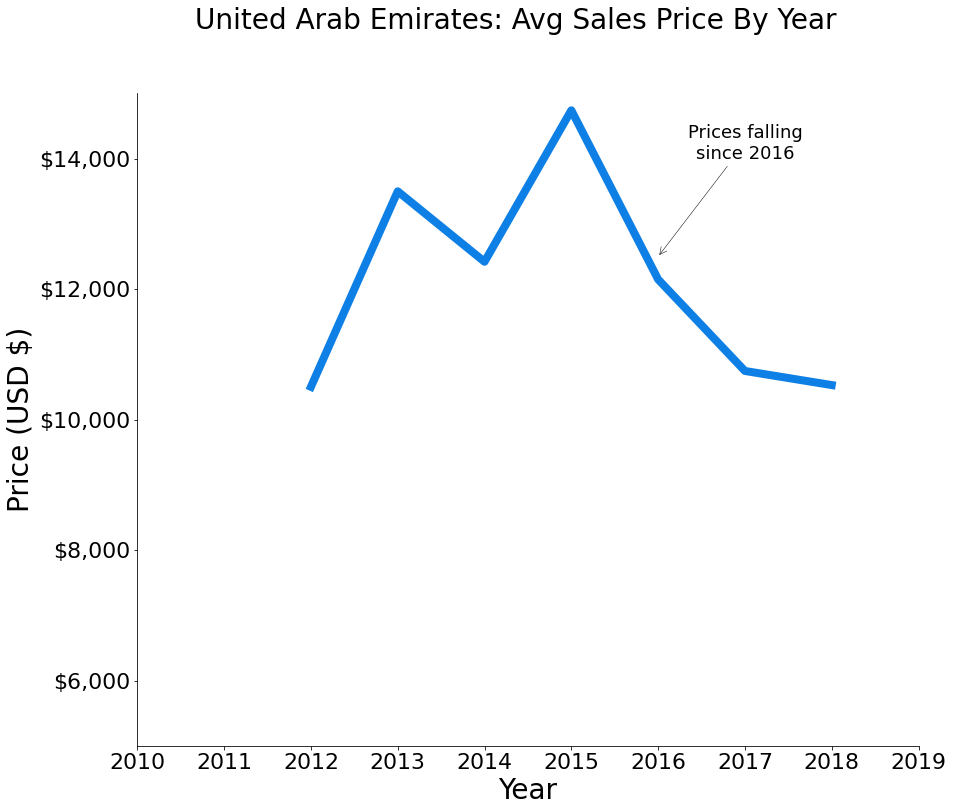

In [27]:
#Note: Formatting is specifically designed to be large to improve readability when embedded in the paper
df_cheetah.where((df_cheetah['Price UOM']=='AED') & (df_cheetah['Units']=='Live') & (df_cheetah['Price USD']>2000) & (df_cheetah['Price USD']<35000) ).groupby(df_cheetah['Incident Date'].dt.year)['Price USD'].mean().plot(kind='line', color='#0d7fe5', label="Average Price", figsize = (14,12), linewidth=8)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

plt.annotate('Prices falling\nsince 2016', xy=(2016, 12500),xytext=(2017, 14000) ,
horizontalalignment="center",fontsize=18, arrowprops=dict(arrowstyle='->',lw=0.5))

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Year', fontsize = 28)
plt.ylim(5000,15000)
plt.xlim(2010,2019)
plt.gca().yaxis.set_major_formatter(tick)
plt.ylabel('Price (USD $)', fontsize = 28)
plt.suptitle('United Arab Emirates: Avg Sales Price By Year', fontsize = 28)
# plt.savefig('United Arab Emirates Avg Sales Price By Year.png')
plt.show()

## Deeper analysis of source of advertisement on social media platforms

In [28]:
df_original_source_instagram = df_cheetah.where(df_cheetah['Original Source'] == 'instagram.com')
df_original_source_facebook = df_cheetah.where(df_cheetah['Original Source'] == 'facebook.com')
df_original_source_twitter = df_cheetah.where(df_cheetah['Original Source'] == 'twitter.com')
df_original_source_whatsapp = df_cheetah.where(df_cheetah['Original Source'] == 'WhatsApp chat group via confidential informant (02)')
df_original_source_youtube = df_cheetah.where(df_cheetah['Original Source'] == 'youtube.com')

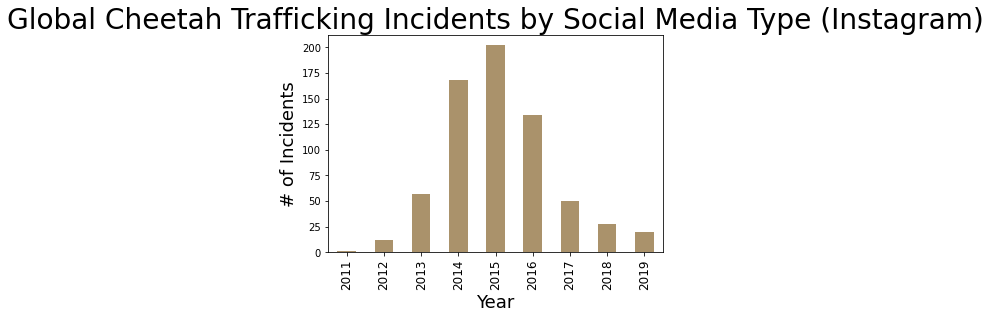

In [29]:
fig2 = df_original_source_instagram.groupby(df_original_source_instagram['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Social Media Type (Instagram)', color='#aa926b')

fig2.axes.title.set_size(28)
fig2.set_xlabel('Year', fontdict={'fontsize':18})
fig2.set_ylabel('# of Incidents', fontdict={'fontsize':18})

plt.xticks(fontsize=12)

fig2.axes.title.set_size(28)
fig2.set_xlabel("Year", fontdict={'fontsize':18})
fig2.set_ylabel("# of Incidents", fontdict={'fontsize':18})
plt.xticks(fontsize=12)

labels = [item.get_text() for item in fig2.get_xticklabels()]
labels[0] = '2011'
labels[1] = '2012'
labels[2] = '2013'
labels[3] = '2014'
labels[4] = '2015'
labels[5] = '2016'
labels[6] = '2017'
labels[7] = '2018'
labels[8] = '2019'
fig2.set_xticklabels(labels);

# plt.savefig('bar_plot_1.png')

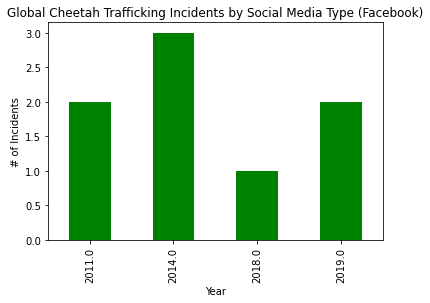

In [30]:
df_original_source_facebook.groupby(df_original_source_facebook['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Social Media Type (Facebook)', color='g');

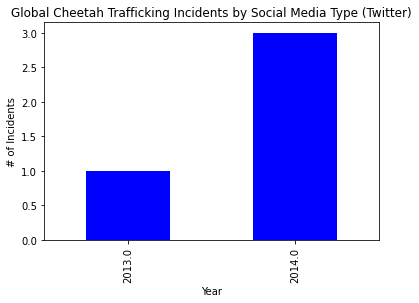

In [31]:
df_original_source_twitter.groupby(df_original_source_twitter['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Social Media Type (Twitter)', color='b');

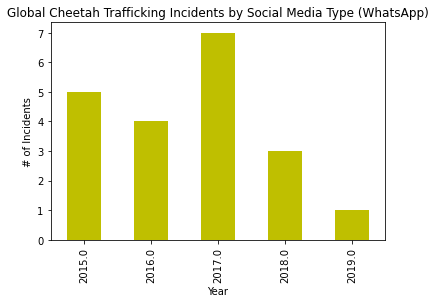

In [32]:
df_original_source_whatsapp.groupby(df_original_source_whatsapp['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Social Media Type (WhatsApp)', color='y');

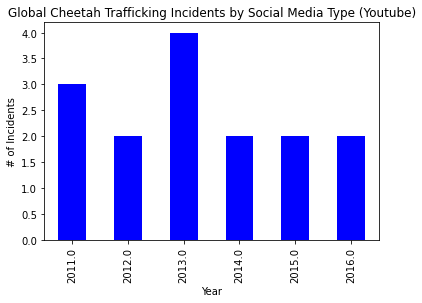

In [33]:
df_original_source_youtube.groupby(df_original_source_youtube['Incident Date'].dt.year).size().plot(kind='bar',ylabel='# of Incidents', xlabel = 'Year', title='Global Cheetah Trafficking Incidents by Social Media Type (Youtube)', color='b');

# Geographic Heatmap of Cheetah Incidents
Instructions on a geographic heat map obtained from: 
https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [34]:
#Number of cheetahs by country 
df_cheetah_country_count = df_cheetah.groupby('Country')['# Cheetahs'].sum().rename_axis('country').to_frame('number_cheetahs').reset_index()
df_cheetah_country_count.sort_values(by = 'number_cheetahs', ascending = False).head(5)

,country,number_cheetahs
25,Saudi Arabia,1006.0
28,Somaliland,386.0
36,UAE,386.0
18,Kenya,285.0
29,South Africa,175.0


In [35]:
#Shapefile obtained from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
shapefile = 'data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Remame columns in shapefile
gdf.columns = ['country', 'country_code', 'geometry']

#Drop Antartica as it is not needed on the world map for this dataset. 
index = gdf[gdf['country'] == 'Antarctica'].index.values
gdf = gdf.drop(gdf.index[index])

/Users/megan/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [36]:
#Alphabetical list of countries in the shapefile. Will need to match country names to cheetah df for later join. 
gdf_country_names = gdf['country'].sort_values(ignore_index = True)

In [37]:
#Checking for spelling differences in country names in the shapefile compared to the cheetah df. 
cheetah_country_names = df_cheetah['Country'].sort_values(ignore_index = True).unique()
for country in cheetah_country_names:
    if country not in gdf_country_names.values:
        print(country + ': False')

Bahrain: False
Singapore: False
Tanzania: False
UAE: False
UK: False
USA: False


# Number of Illegal Cheetahs Traded by Country Geographic Heatmap

In [38]:
#Creating dataframe of number of cheetahs by country
df_cheetah_country_count = df_cheetah.groupby('Country')['# Cheetahs'].sum().to_frame('Number of Cheetahs').reset_index()
#Rename column for future merge
df_cheetah_country_count.rename(columns = {'Country': 'country'}, inplace = True)

In [39]:
#Rename countries for merge
#Note that Bahrain and Singapore are not included in the world map due to size/visualization limitations. 
country_rename = {'Tanzania': 'United Republic of Tanzania',
                  'UAE':'United Arab Emirates',
                  'UK': 'United Kingdom',
                  'USA': 'United States of America'}

df_cheetah_country_count.replace({'country': country_rename}, inplace = True)

In [40]:
#Join Country data frame and Cheetah Incident Count dataframe:
merged_country_df = pd.merge(gdf, df_cheetah_country_count, on = 'country', how = 'left')

In [41]:
#Read data to json.
merged_json = json.loads(merged_country_df.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [42]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = Turbo256
#Slice color palette to get green-yellow-red.
palette = palette[140:256]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1000, nan_color = '#f2f4f7' )

#Define custom tick label for color bar. 
tick_labels = {'1000': '1000+'}

#Adjust ticker on color bar. 
ticker = FixedTicker(ticks=[1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 400, 500, 600, 700, 800, 900, 1000])
#Create color bar. 
color_bar = ColorBar(color_mapper = color_mapper, ticker = ticker, label_standoff = 8,width = 500, height = 20,
            border_line_color = None, location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object and specifications.
p = figure(title = 'Number of Illegal Cheetahs Traded by Country', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.title.text_font_size = '28pt'
p.xaxis.axis_label_text_font_size = "18pt"
p.yaxis.axis_label_text_font_size = "18pt"
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Number of Cheetahs', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
show(p)
#Save figure as .png to use in report
#Export method requires install of selenium 3.141.0 and downgrade of shapely from  which is incompatable with current geopandas requirements. 
# export_png(p, filename = 'geographic_heatmap.png')

Loading BokehJS ...

## What are the trends of incidents by region by year? 

In [43]:
palette = 'terrain'
palette = palette[140:256]

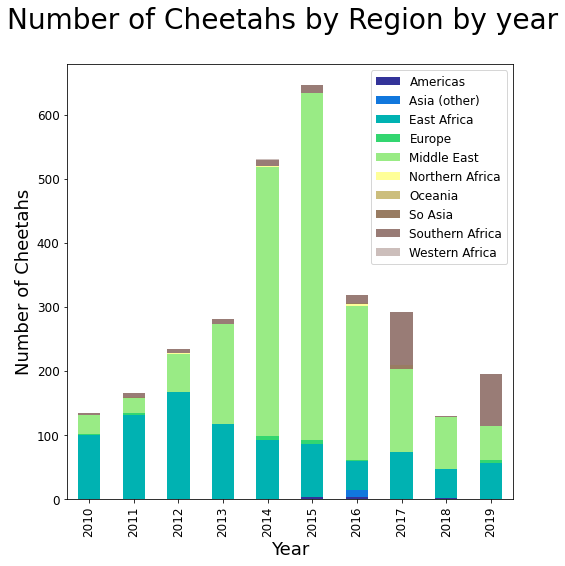

In [44]:
df_cheetah.groupby(['Year', 'Region'])['# Cheetahs'].sum().unstack().plot(kind = 'bar', stacked = True, figsize = (8,8), color = hex_list)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Number of Cheetahs', fontsize = 18)
plt.suptitle('Number of Cheetahs by Region by year', fontsize = 28)
plt.legend(fontsize = 12, loc = 'upper right')
# plt.savefig('Number of Cheetahs by Region by Year.png')
plt.show()


## Type of illegal trade activity

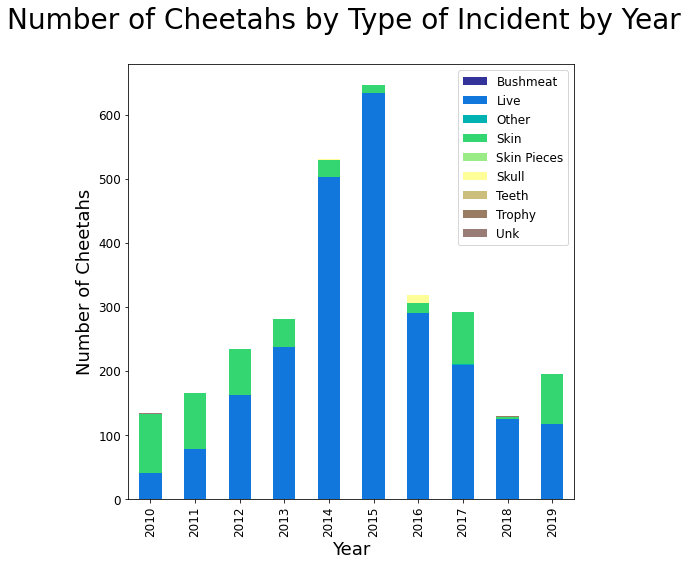

In [45]:
df_cheetah.groupby(['Year', 'Units'])['# Cheetahs'].sum().unstack().plot(kind='bar', stacked = True, figsize = (8,8), color = hex_list)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Number of Cheetahs', fontsize = 18)
plt.suptitle('Number of Cheetahs by Type of Incident by Year', fontsize = 28)
plt.legend(fontsize = 12, loc = 'upper right')
# plt.savefig('Number of Cheetahs by Type of Incident by Year.png')
plt.show()



In [46]:
#Proportion of incident type in dataset
incident_type_proportion = df_cheetah['Units'].value_counts(normalize = True)
incident_type_proportion

Live           0.899657
Skin           0.084048
Other          0.003431
Skull          0.003431
Teeth          0.003431
Skin Pieces    0.002573
Unk            0.001715
Bushmeat       0.000858
Trophy         0.000858
Name: Units, dtype: float64